# Essay Scoring Challenge

In [1]:
#Data Wrangling
import pandas as pd
import numpy as np
import nltk
nltk.download('brown')
from nltk.corpus import brown
import re
import string
from nltk.stem.porter import *
from scipy.sparse import csr_matrix, hstack
import spacy

#Utils
import random
import os
from six.moves.urllib.request import urlretrieve
import zipfile

#Machine Learning
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout, Conv1D, Flatten, Bidirectional
from keras import losses
from keras.optimizers import SGD, Adam
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve, auc

#Data Vizualization
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package brown to /Users/gdamien/nltk_data...
[nltk_data]   Package brown is already up-to-date!


/Users/gdamien/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


## Data Analysis

In [154]:
df_train = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding='latin-1', quotechar='"')

In [155]:
df_train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
print("Number of NaN scores is:",np.isnan(df_train["domain1_score"]).sum())

Number of NaN scores is: 0


In [157]:
#Number of essay sets
print("Number of essays:", len(df_train))
print("Number of essay sets:", len(set(df_train['essay_set'].tolist())))

Number of essays: 12976
Number of essay sets: 8


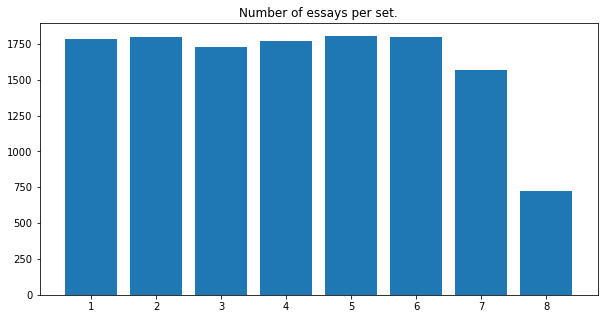

In [158]:
set_ids = df_train["essay_set"].value_counts().keys().tolist()
essays_per_set = df_train["essay_set"].value_counts().values

plt.figure(figsize=(10,5))
plt.bar(set_ids, essays_per_set)
plt.title("Number of essays per set.")
plt.show()

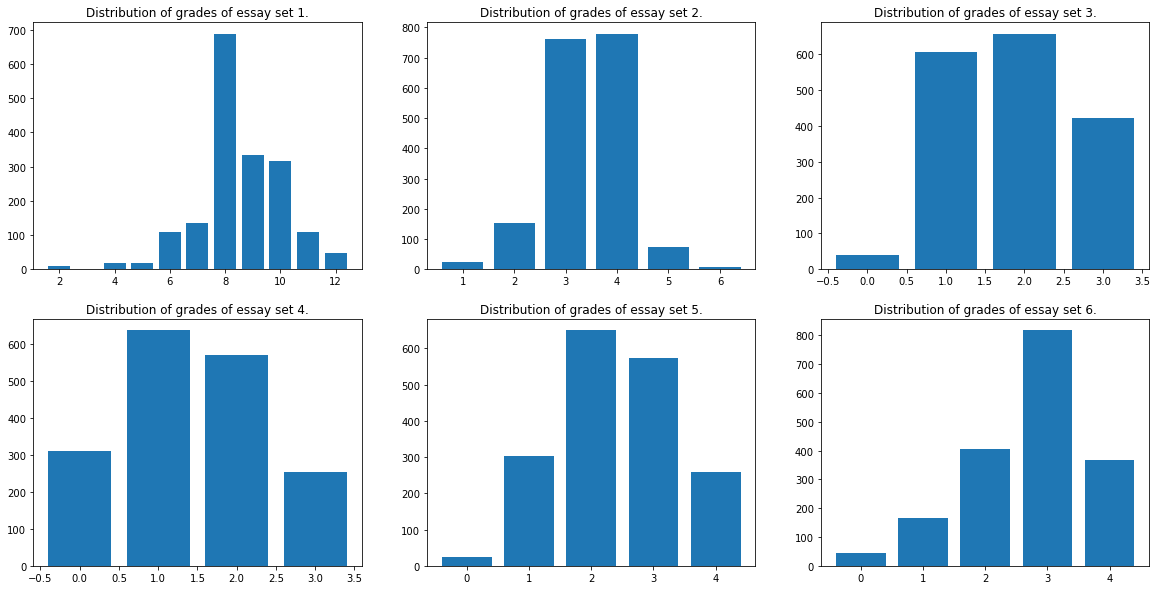

In [159]:
plt.figure(figsize=(20,10))

for set_id in range(1, 7):
    
    plt.subplot(2, 3, set_id)
    
    grades_ids = df_train["domain1_score"][df_train["essay_set"]==set_id].value_counts().keys().tolist()
    grades_values = df_train["domain1_score"][df_train["essay_set"]==set_id].value_counts().values

    plt.bar(grades_ids, grades_values)
    plt.title("Distribution of grades of essay set {}.".format(set_id))

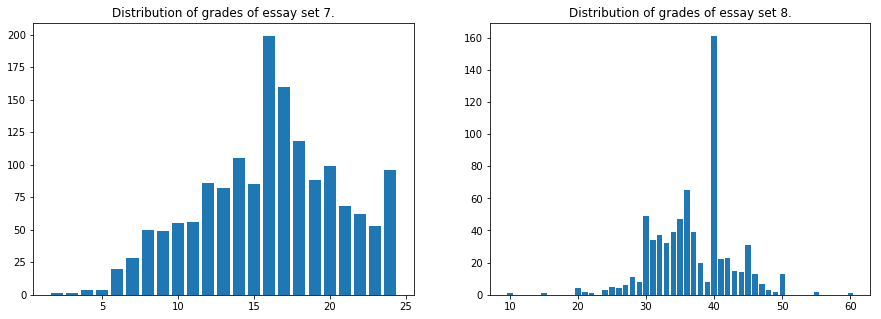

In [160]:
plt.figure(figsize=(15,5))

for set_id in range(1, 3):
    
    plt.subplot(1, 2, set_id)
    set_id +=6
    
    grades_ids = df_train["domain1_score"][df_train["essay_set"]==set_id].value_counts().keys().tolist()
    grades_values = df_train["domain1_score"][df_train["essay_set"]==set_id].value_counts().values

    plt.bar(grades_ids, grades_values)
    plt.title("Distribution of grades of essay set {}.".format(set_id))

In [161]:
#Sample essays
print("Essay scored 0:")
print()
print(df_train["essay"][df_train["rater1_domain1"]==0].tolist()[0])
print()
print("Essay scored 10:")
print()
print(df_train["essay"][df_train["rater1_domain1"]==10].tolist()[0])
print()
print("--> The difference in writing style is striking: the latter extract is more grammatically correct, \
uses conjonction words (but, then, etc.), and have longer sentences.")

Essay scored 0:

The affects of the cyclist is if it does not change. it cut hurt a lot of people feeling because they @CAPS1 dont care about the cyclist. Im one of them people who does not care about it cause it does not affect me or anyone I know. It is a big deal to write people, some of them @CAPS1 blow stuff up. They talking on tiv and on the radio making all this stuff they say is made up. I dont believe to I see it. That @CAPS1 not for black people because it has not did anything to us. We really dont care about the affects of the cyclist.

Essay scored 10:

One day, a few years ago, I woke up and my mom said we were going  to my grandmas house. So started to get ready. After I was done getting dressed I looked on.  My dresser and grabbed my @MONEY2 @MONEY3 that I was saving up to buy something just incase we went to the store When we got there I saw my cousins dad @CAPS1 walking a puppy. I walked up to him and asked about the dog, he said it was his brothers dog and he wa

## Data Preprocessing

In [162]:
#We take a subset of the training dataset:
df_train = df_train[df_train["essay_set"]==5]
df_train.reset_index(inplace=True)

In [163]:
set_words = set(brown.words())
punctuation = set(string.punctuation)

#Number of words
def count_words(text):
    text = ''.join([w for w in text.lower() if w not in punctuation])
    tokens = nltk.word_tokenize(text)
    count = len(tokens)
    return count

df_train["nb_words"] = df_train["essay"].apply(count_words)

#Number of sentences
def count_sentences(text):
    sents = nltk.sent_tokenize(text)
    count = len(sents)
    return count

df_train["nb_sents"] = df_train["essay"].apply(count_sentences)

#Average sentence length
def average_sentence_length(text):
    return np.mean([count_words(s) for s in nltk.sent_tokenize(text)])

df_train["avg_sent_length"] = df_train["essay"].apply(average_sentence_length)

#Number of distinct words
def unique_words_ratio(text):
    text = ''.join([w for w in text.lower() if w not in punctuation])
    tokens = nltk.word_tokenize(text)
    count = len(set(tokens))
    return count / len(tokens)

df_train["unique_words_ratio"] = df_train["essay"].apply(unique_words_ratio)

#Number of verbs

#Number of nouns

#Number of prepositions

#Number of spelling mistakes
def spelling_mistakes_ratio(text):
    text = ''.join([w for w in text.lower() if w not in punctuation])
    tokens = nltk.word_tokenize(text)
    spelling_mistakes = len([word for word in tokens if word not in set_words and '@' not in word])
    return spelling_mistakes / len(text.split())

df_train["spelling_mistakes_ratio"] = df_train["essay"].apply(spelling_mistakes_ratio)

In [164]:
df_train.head()

,index,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,...,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,nb_words,nb_sents,avg_sent_length,unique_words_ratio,spelling_mistakes_ratio
0,7079,11827,5,"In this memoir of Narciso Rodriguez, @PERSON3'...",2,2,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,132,8,16.500000,0.621212,0.098485
1,7080,11828,5,Throughout the excerpt from Home the Blueprint...,2,2,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,167,7,23.857143,0.610778,0.041916
2,7081,11829,5,The mood the author created in the memoir is l...,3,3,NaN,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,109,6,18.166667,0.724771,0.082569
3,7082,11830,5,The mood created by the author is showing how ...,1,0,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,71,3,23.666667,0.591549,0.169014
4,7083,11831,5,The mood created in the memoir is happiness an...,2,3,NaN,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,127,8,15.875000,0.535433,0.055118


In [165]:
def clean_text_regex(text):

    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)
    text = re.sub(r"\'s", " \'s", text)
    text = re.sub(r"\'ve", " \'ve", text)
    text = re.sub(r"n\'t", " n\'t", text)
    text = re.sub(r"\'re", " \'re", text)
    text = re.sub(r"\'d", " \'d", text)
    text = re.sub(r"\'ll", " \'ll", text)
    text = re.sub(r",", " , ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", " ( ", text)
    text = re.sub(r"\)", " ) ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\s{2,}", " ", text)

    punctuation = set(string.punctuation)
    text = ''.join([w for w in text.lower() if w not in punctuation])

    # Stemming
    stemmer = PorterStemmer()
    text = [stemmer.stem(w) for w in text.split()]

    # Covenrt list of words to one string
    text = ' '.join(w for w in text)

    return text

In [166]:
raw_text = df_train["essay"][df_train["rater1_domain1"]==1].tolist()[0]
print("-------------")
print("Initial text:")
print("-------------")
print()
print(raw_text)
print()


clean_text = clean_text_regex(raw_text)
print("-------------")
print("Cleaned text:")
print("-------------")
print()
print(clean_text)

-------------
Initial text:
-------------

The mood created by the author is showing how cuban's lived and about Their cultra and how they lived and some people from other cultra's could be diffrent and don't @CAPS1 cared about their cultra's and some people do care about their cultra like narciso parents. that is what the author is trying to say. and that some people should respect their cultra and not @CAPS2 To be a different cultra.

-------------
Cleaned text:
-------------

the mood creat by the author is show how cuban s live and about their cultra and how they live and some peopl from other cultra s could be diffrent and do nt caps1 care about their cultra s and some peopl do care about their cultra like narciso parent that is what the author is tri to say and that some peopl should respect their cultra and not caps2 to be a differ cultra


In [167]:
#Clean essays
df_train['clean_essay'] = df_train['essay'].apply(clean_text_regex)

#Create TD-IDF vectors
tf = TfidfVectorizer(min_df=2, ngram_range=(1,3))
train_tfidf_matrix = tf.fit_transform(df_train['clean_essay'])

In [168]:
df_labels = df_train["domain1_score"]
#df_variables = hstack([csr_matrix(df_train[["nb_words", "nb_sents", "avg_sent_length", "unique_words_ratio", "spelling_mistakes_ratio"]].values), train_tfidf_matrix])
df_variables = df_train[["nb_words", "nb_sents", "avg_sent_length", "unique_words_ratio", "spelling_mistakes_ratio"]].values

## Model Construction

In [169]:
#Create training and test set
X_train, X_test, y_train, y_test = train_test_split(df_variables, df_labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1444, 5) (361, 5) (1444,) (361,)


### 1. Logistic Regression

In [170]:
#Logistic Regression
lr = LogisticRegression(C=1, random_state = 42, class_weight = 'balanced')
lr.fit(X_train, y_train)

predictions = lr.predict(X_test)

In [171]:
print('\nConfusion matrix\n', confusion_matrix(predictions, y_test))
print()
print(classification_report(predictions, y_test))


Confusion matrix
 [[ 0  0  0  0  0]
 [ 6 31 26  0  0]
 [ 1 15 79 19  0]
 [ 0  2 25 71 12]
 [ 0  0  5 35 34]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.65      0.49      0.56        63
          2       0.59      0.69      0.63       114
          3       0.57      0.65      0.60       110
          4       0.74      0.46      0.57        74

avg / total       0.62      0.60      0.60       361



### 2. Random Forest

In [172]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

In [173]:
print('\nConfusion matrix\n', confusion_matrix(predictions, y_test))
print()
print(classification_report(predictions, y_test))


Confusion matrix
 [[ 0  1  0  0  0]
 [ 6 24 15  0  0]
 [ 1 20 94 21  1]
 [ 0  2 22 81 15]
 [ 0  1  4 23 30]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.50      0.53      0.52        45
          2       0.70      0.69      0.69       137
          3       0.65      0.68      0.66       120
          4       0.65      0.52      0.58        58

avg / total       0.65      0.63      0.64       361



### 3. XGBoost

In [174]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)

xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)

In [175]:
print('\nConfusion matrix\n', confusion_matrix(predictions, y_test))
print()
print(classification_report(predictions, y_test))


Confusion matrix
 [[ 0  2  0  0  0]
 [ 7 21 17  0  0]
 [ 0 22 89 22  1]
 [ 0  2 25 81 21]
 [ 0  1  4 22 24]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.44      0.47      0.45        45
          2       0.66      0.66      0.66       134
          3       0.65      0.63      0.64       129
          4       0.52      0.47      0.49        51

avg / total       0.60      0.60      0.60       361



### 4. Averaging the three models

In [176]:
#Logistic Regression
lr = LogisticRegression(C=1, random_state = 42, class_weight = 'balanced')
lr.fit(X_train, y_train)

predictions_lr = lr.predict_proba(X_test)

#Random Forest
rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
rf.fit(X_train, y_train)

predictions_rf = rf.predict_proba(X_test)

#XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)

xgb_model.fit(X_train, y_train)

predictions_xgb = xgb_model.predict_proba(X_test)

#Average of predictions
random.seed(9001)
rd = np.random.random(3)
rd /= 3
alpha, beta, gamma = rd[0], rd[1], rd[2]
predictions = np.argmax((alpha*predictions_rf + beta*predictions_lr + gamma*predictions_xgb)/3, axis=1)

In [177]:
print('\nConfusion matrix\n', confusion_matrix(predictions, y_test))
print()
print(classification_report(predictions, y_test))


Confusion matrix
 [[ 0  2  0  0  0]
 [ 7 23 18  0  0]
 [ 0 20 86 23  0]
 [ 0  2 26 77 20]
 [ 0  1  5 25 26]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.48      0.48      0.48        48
          2       0.64      0.67      0.65       129
          3       0.62      0.62      0.62       125
          4       0.57      0.46      0.50        57

avg / total       0.59      0.59      0.59       361



In [178]:
str(100*np.round(sum([np.abs(p-s)==0 for p,s in zip(predictions, y_test)])/len(predictions), 4)) + "%"

'58.730000000000004%'

### 5. Use of Glove word embeddings

In [179]:
def maybe_download(filename):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    return filename

In [180]:
url = 'http://nlp.stanford.edu/data/wordvecs/'

filename = maybe_download('glove.6B.zip')

if not os.path.exists('glove'):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('glove')
    zip_ref.close()
    
embeddings_index = {}
f = open(os.path.join('glove','glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype ='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [181]:
train_glove_bow = np.zeros((len(df_train), 300))
for index in range(len(df_train)):
    essay_vector = np.zeros((1, 300))
    for word in df_train["essay"][index].split():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            essay_vector += embedding_vector
    train_glove_bow[index, :] = essay_vector

In [182]:
df_variables = np.hstack([df_train[["nb_words", "nb_sents", "avg_sent_length", "unique_words_ratio", "spelling_mistakes_ratio"]].values, train_glove_bow])

In [183]:
#Create training and test set
X_train, X_test, y_train, y_test = train_test_split(train_glove_bow, df_labels, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1624, 300) (181, 300) (1624,) (181,)


In [184]:
#Logistic Regression
lr = LogisticRegression(C=1, random_state = 42, class_weight = 'balanced')
lr.fit(X_train, y_train)

predictions = lr.predict(X_test)

In [185]:
print('\nConfusion matrix\n', confusion_matrix(predictions, y_test))
print()
print(classification_report(predictions, y_test))


Confusion matrix
 [[ 0  2  0  0  0]
 [ 3  9 18  2  0]
 [ 0 10 32 14  1]
 [ 0  1 12 34 12]
 [ 0  0  3 16 12]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.41      0.28      0.33        32
          2       0.49      0.56      0.52        57
          3       0.52      0.58      0.54        59
          4       0.48      0.39      0.43        31

avg / total       0.48      0.48      0.47       181



### 6. Fully Connected Artificial Neural Network on Bag of Words (average) using Glove word embeddings

In [186]:
def create_doc2vec(df):
    doc2vec = np.zeros((len(df_train), 300))
    for index in range(len(df_train)):
        essay_vector = np.zeros((1, 300))
        for word in df["essay"][index].split():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                essay_vector += embedding_vector
        doc2vec[index, :] = essay_vector
    return doc2vec

train = create_doc2vec(df_train)
le = preprocessing.LabelEncoder()
labels = le.fit_transform(df_train["domain1_score"].values)

In [187]:
#Create training and test set
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1624, 300) (181, 300) (1624,) (181,)


In [188]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, len(set(labels.tolist())))

In [190]:
# define model
print('Build model...')
model = Sequential()
model.add(Dense(500, activation='tanh', input_dim=300))
model.add(Dropout(0.2))
model.add(Dense(300, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(200, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(set(labels.tolist())), activation='softmax'))
print(model.summary())
# compile network
# Compile the model
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd , metrics=['mean_squared_error','accuracy'])
# fit network
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=50, verbose=1)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 500)               150500    
_________________________________________________________________
dropout_65 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 300)               150300    
_________________________________________________________________
dropout_66 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 200)               60200     
_________________________________________________________________
dropout_67 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 100)               20100 

In [191]:
predictions = np.argmax(model.predict(X_test), axis=1)
print('\nConfusion matrix\n', confusion_matrix(predictions, y_test))
print()
print(classification_report(predictions, y_test))


Confusion matrix
 [[ 0  0  0  0  0]
 [ 3  9  8  0  0]
 [ 0 12 31 19  1]
 [ 0  1 26 46 24]
 [ 0  0  0  1  0]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.41      0.45      0.43        20
          2       0.48      0.49      0.48        63
          3       0.70      0.47      0.56        97
          4       0.00      0.00      0.00         1

avg / total       0.58      0.48      0.52       181



### 7. One-layer RNN (GRU) on word sequences using Glove word embeddings

In [192]:
vocabularySize = 10000
tokenizer = Tokenizer(num_words = vocabularySize, filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')

tokenizer.fit_on_texts(df_train["essay"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5052 unique tokens.


In [193]:
embedding_matrix = np.zeros((len(word_index)+1,300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [194]:
max_seq_length = max([len(s.split()) for s in df_train["essay"].tolist()])
print("Maximum length of an essay is:", max_seq_length)

Maximum length of an essay is: 416


In [195]:
def create_train_dataset(max_seq_length=max_seq_length):
    sequences = tokenizer.texts_to_sequences(df_train["essay"].tolist())
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='pre')
    return sequences

df_train = df_train.sample(frac=1).reset_index(drop=True)
train = create_train_dataset(max_seq_length=max_seq_length)
le = preprocessing.LabelEncoder()
labels = le.fit_transform(df_train["domain1_score"].values)

In [196]:
#Create training and test set
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1624, 416) (181, 416) (1624,) (181,)


In [197]:
set(labels.tolist())

{0, 1, 2, 3, 4}

In [198]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, len(set(labels.tolist())))

In [199]:
# define model
print('Build model...')
model = Sequential()
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
#model.add(Dropout(0.3))
model.add(GRU(256))
#model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(set(labels.tolist())), activation='softmax'))
print(model.summary())
# compile network
optimizer = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#optimizer = Adam(lr=0.01) #SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mean_squared_error','accuracy'])
# fit network
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=10, verbose=1)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 416, 300)          1515900   
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               427776    
_________________________________________________________________
dense_108 (Dense)            (None, 50)                12850     
_________________________________________________________________
dense_109 (Dense)            (None, 5)                 255       
Total params: 1,956,781
Trainable params: 440,881
Non-trainable params: 1,515,900
_________________________________________________________________
None
Train on 1461 samples, validate on 163 samples
Epoch 1/10
1461/1461 [==============================] - 56s - loss: 1.5685 - mean_squared_error: 0.1567 - acc: 0.2902 - val_loss: 1.5491 - val_mean_squared_error: 0.1553 - val_acc: 0.3129
Epo

In [200]:
predictions = np.argmax(model.predict(X_test), axis=1)
print('\nConfusion matrix\n', confusion_matrix(predictions, y_test))
print()
print(classification_report(predictions, y_test))


Confusion matrix
 [[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 1 23 45 34 18]
 [ 3  8 15 20 12]
 [ 0  0  1  1  0]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00         0
          2       0.74      0.37      0.49       121
          3       0.36      0.34      0.35        58
          4       0.00      0.00      0.00         2

avg / total       0.61      0.36      0.44       181



### 8. One layer BiLSTM

In [201]:
# define model
print('Build model...')
model = Sequential()
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(Bidirectional(LSTM(100, return_sequences=True)))#, input_shape=(5, 10)))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(len(set(labels.tolist())), activation='softmax'))
print(model.summary())
# compile network
optimizer = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#optimizer = Adam(lr=0.01) #SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mean_squared_error','accuracy'])
# fit network
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=10, verbose=1)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 416, 300)          1515900   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 416, 200)          320800    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_110 (Dense)            (None, 5)                 1005      
Total params: 2,078,505
Trainable params: 562,605
Non-trainable params: 1,515,900
_________________________________________________________________
None
Train on 1461 samples, validate on 163 samples
Epoch 1/10
1461/1461 [==============================] - 96s - loss: 1.5905 - mean_squared_error: 0.1586 - acc: 0.2834 - val_loss: 1.5970 - val_mean_squared_error: 0.1590 - val_acc: 0.2638
Epo

In [147]:
predictions = np.argmax(model.predict(X_test), axis=1)
print('\nConfusion matrix\n', confusion_matrix(predictions, y_test))
print()
print(classification_report(predictions, y_test))


Confusion matrix
 [[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  3 10  6  2  0]
 [ 2  5 71 74  5  1]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00         0
          2       0.12      0.45      0.19        22
          3       0.93      0.47      0.62       158
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         0

avg / total       0.83      0.47      0.57       180

